In [1]:
# Mofication History
# v0.1 Initial
# v0.2 run in my laptop
# v0.3 run 3 models

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

import imgaug as ia
from imgaug import augmenters as iaa


%matplotlib inline
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from os import listdir
from os.path import join, basename, isdir, isfile
import shutil

from PIL import Image
import time


In [3]:
# Parameter Claim
BATCH_SIZE = 128        # Batch Size
LR         = 0.1        # Initial Learning Rate
FREQ_SSR   = 4          # Times for showing accuracy for each epoch
EPOCH      = 200        # Training Epoches
SAVE_ALL   = True       # SAVE ALL model or just architecture
IMAGE_SIZE = 224        # Image dimension
DO_TRAIN   = True       # Do train or only inference
MOMENTUM   = 0.9        # Momentum
W_DECAY    = 1e-4       # Weight Decay
GOAL_ACCU  = 95         # Early stop at goal accuracy
RESUME     = True       # Resume best training or start form epoch 0
UPDATE_ALL = False      # Update all parameter
device     = 'cuda'
MODEL_SEL  = 2          # 0:model_scrach, 1:model_all, 2:model_last

In [4]:
def train_model(data_loader, model, criterion, optimizer, epoch, scheduler=None, is_train=True):
    # switch to train or test mode
    model.train(is_train)
    if is_train and scheduler!=None:
        scheduler.step()
        
    running_loss = 0.0
    running_corrects = 0
    total_loss = 0.0
    total_corrects = 0
    
    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device) 
        labels = labels.to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        # backward + optimize only if in training phase
        if is_train:
            loss.backward()
            optimizer.step()
            
        # statistics
        running_loss += loss.item()
        running_corrects += preds.eq(labels).sum().item()
        
    # Record statistics
    epoch_acc = 100.*running_corrects/(len(data_loader)*BATCH_SIZE)
    epoch_loss = running_loss / len(data_loader)
    
    if is_train:
        print('{:3d} epoch, training '.format(epoch+1), end='')
    else:
        print('            testing ', end='')
    print('accuracy: {:.1f}%'.format(epoch_acc))
    print('                    loss    : {:.3f}'.format(epoch_loss))
    return epoch_acc, epoch_loss

In [5]:
def transformation(size=224, aug=False):
    if aug:
        return transforms.Compose([
            transforms.RandomResizedCrop(size),
            transforms.RandomAffine(45),
            transforms.RandomRotation(90),
            transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize((0.555, 0.451, 0.344), (0.228, 0.238, 0.238)),
        ])       
        

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


class DatasetFromFolder(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        self.transform = transform

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        input = Image.open(filename)
        #label = basename(filename).split('_', 1)[0]
        if self.transform:
            input = self.transform(input)
        label = basename(filename).split('_')[0:2]
        if label[0].isdigit():
            label = label[0]
        else:
            label = label[1]
        #print("filename, label", filename, label)
        return input, int(label)

    def __len__(self):
        return len(self.image_filenames)
    
    
def get_data_set(datadir, subdir='Food-11/training', aug=False):
    train_dir = join(datadir, subdir)
    return DatasetFromFolder(train_dir, transform=transformation(IMAGE_SIZE, aug))


def adjust_learning_rate(optimizer, epoch):
    lr = LR * (0.5 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    if epoch%20 == 0:
        print('Learning rate is {:.5f}'.format(lr))

In [6]:
# Main function
if __name__ == '__main__':
    classes = ('Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice',
               'Seafood', 'Soup', 'Vegetable/Fruit')
    
    mode = ['scrach', 'all', 'last']
    
    # Data loading
    datadir = '../data'
    if not isdir(datadir):
        datadir = '/tmp/dataset-nctu'
    
    trainset = get_data_set('/tmp/work', 'LAB3-2/sampled_train', True)
    validset = get_data_set(datadir, 'Food-11/validation')
    TRAIN_SIZE, VALID_SIZE = len(trainset), len(validset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
      

    best_accu = [0, 0, 0]
    train_accu, train_loss = [[],[],[]], [[],[],[]]
    val_accu, val_loss = [[],[],[]], [[],[],[]]
    
    for idx in range(3): #0:model_scrach, 1:model_all, 2:model_last
        print('Transfer learning mode {} is begining...'.format(mode[idx]))
        criterion = nn.CrossEntropyLoss()
        scheduler = None   
        
        if idx==0: # Training from scrach
            model = models.resnet18()
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
            
        elif idx==1: # Transfer learning and update all weights
            model = models.resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
            
        else: # Transfer learning and update only last layer's weight
            model = models.resnet18(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False # do not update gradient
            model.fc = nn.Linear(model.fc.in_features, len(classes))
            optimizer = optim.SGD(model.fc.parameters(), LR, momentum=MOMENTUM)
       
        model = model.to(device)

        # Do Training
        for epoch in range(EPOCH):
            # Adjust learning rate
            adjust_learning_rate(optimizer, epoch)

            # train for one epoch
            accu_t, loss_t = train_model(trainloader, model, criterion, optimizer, epoch, scheduler)
            train_accu[idx].append(accu_t)
            train_loss[idx].append(loss_t)
            accu_v, loss_v = train_model(validloader, model, criterion, optimizer, epoch, scheduler, False)
            val_accu[idx].append(accu_v)
            val_loss[idx].append(loss_v)
            if accu_v > best_accu[idx]:
                best_accu[idx] = accu_v
                fname = './ckpt/model_best_'+mode[idx]+'.pth.tar'
                torch.save(model.state_dict(), fname)

        #print('Transfer learning mode {} is DONE.'.format(mode[idx]))
        del criterion
        del scheduler 
        del model
        del optimizer
    
    print('\n\nTransfer learning is DONE.')


Transfer learning mode scrach is begining...
Learning rate is 0.10000
  1 epoch, training accuracy: 9.3%
                    loss    : 5.026
            testing accuracy: 10.5%
                    loss    : 117465.728
  2 epoch, training accuracy: 9.6%
                    loss    : 4.650
            testing accuracy: 10.0%
                    loss    : 4620.044
  3 epoch, training accuracy: 9.3%
                    loss    : 3.205
            testing accuracy: 6.8%
                    loss    : 770.783
  4 epoch, training accuracy: 10.4%
                    loss    : 2.945
            testing accuracy: 11.8%
                    loss    : 15.735
  5 epoch, training accuracy: 10.9%
                    loss    : 2.628
            testing accuracy: 14.3%
                    loss    : 2.670
  6 epoch, training accuracy: 11.4%
                    loss    : 2.595
            testing accuracy: 16.5%
                    loss    : 2.545
  7 epoch, training accuracy: 11.7%
                    los

            testing accuracy: 27.8%
                    loss    : 2.064
 58 epoch, training accuracy: 28.3%
                    loss    : 1.942
            testing accuracy: 24.7%
                    loss    : 2.135
 59 epoch, training accuracy: 30.7%
                    loss    : 1.881
            testing accuracy: 25.6%
                    loss    : 2.119
 60 epoch, training accuracy: 30.8%
                    loss    : 1.875
            testing accuracy: 24.6%
                    loss    : 2.144
Learning rate is 0.01250
 61 epoch, training accuracy: 31.2%
                    loss    : 1.877
            testing accuracy: 25.6%
                    loss    : 2.086
 62 epoch, training accuracy: 29.5%
                    loss    : 1.872
            testing accuracy: 27.2%
                    loss    : 2.092
 63 epoch, training accuracy: 29.9%
                    loss    : 1.867
            testing accuracy: 28.1%
                    loss    : 2.029
 64 epoch, training accuracy: 32.5%
   

114 epoch, training accuracy: 40.1%
                    loss    : 1.687
            testing accuracy: 32.4%
                    loss    : 2.004
115 epoch, training accuracy: 37.8%
                    loss    : 1.682
            testing accuracy: 34.0%
                    loss    : 1.942
116 epoch, training accuracy: 38.4%
                    loss    : 1.662
            testing accuracy: 33.4%
                    loss    : 1.979
117 epoch, training accuracy: 39.9%
                    loss    : 1.643
            testing accuracy: 33.4%
                    loss    : 1.929
118 epoch, training accuracy: 39.5%
                    loss    : 1.644
            testing accuracy: 33.8%
                    loss    : 1.960
119 epoch, training accuracy: 40.6%
                    loss    : 1.615
            testing accuracy: 34.2%
                    loss    : 1.956
120 epoch, training accuracy: 42.4%
                    loss    : 1.603
            testing accuracy: 33.9%
                    loss    

            testing accuracy: 34.5%
                    loss    : 1.931
171 epoch, training accuracy: 43.2%
                    loss    : 1.547
            testing accuracy: 35.5%
                    loss    : 1.905
172 epoch, training accuracy: 43.4%
                    loss    : 1.530
            testing accuracy: 35.3%
                    loss    : 1.910
173 epoch, training accuracy: 42.2%
                    loss    : 1.547
            testing accuracy: 35.0%
                    loss    : 1.900
174 epoch, training accuracy: 44.4%
                    loss    : 1.532
            testing accuracy: 35.1%
                    loss    : 1.914
175 epoch, training accuracy: 43.2%
                    loss    : 1.559
            testing accuracy: 35.3%
                    loss    : 1.919
176 epoch, training accuracy: 43.9%
                    loss    : 1.551
            testing accuracy: 35.2%
                    loss    : 1.921
177 epoch, training accuracy: 41.8%
                    loss    

            testing accuracy: 13.3%
                    loss    : 2.332
 28 epoch, training accuracy: 18.5%
                    loss    : 2.231
            testing accuracy: 13.2%
                    loss    : 2.365
 29 epoch, training accuracy: 18.5%
                    loss    : 2.230
            testing accuracy: 11.9%
                    loss    : 2.408
 30 epoch, training accuracy: 19.6%
                    loss    : 2.207
            testing accuracy: 14.7%
                    loss    : 2.348
 31 epoch, training accuracy: 18.4%
                    loss    : 2.218
            testing accuracy: 13.7%
                    loss    : 2.368
 32 epoch, training accuracy: 20.0%
                    loss    : 2.194
            testing accuracy: 14.3%
                    loss    : 2.428
 33 epoch, training accuracy: 20.1%
                    loss    : 2.213
            testing accuracy: 13.1%
                    loss    : 2.384
 34 epoch, training accuracy: 20.1%
                    loss    

 84 epoch, training accuracy: 29.2%
                    loss    : 2.035
            testing accuracy: 23.5%
                    loss    : 2.161
 85 epoch, training accuracy: 26.9%
                    loss    : 2.040
            testing accuracy: 23.7%
                    loss    : 2.143
 86 epoch, training accuracy: 26.4%
                    loss    : 2.028
            testing accuracy: 22.0%
                    loss    : 2.181
 87 epoch, training accuracy: 26.1%
                    loss    : 2.034
            testing accuracy: 25.8%
                    loss    : 2.124
 88 epoch, training accuracy: 27.9%
                    loss    : 2.018
            testing accuracy: 25.7%
                    loss    : 2.119
 89 epoch, training accuracy: 27.3%
                    loss    : 2.021
            testing accuracy: 25.6%
                    loss    : 2.117
 90 epoch, training accuracy: 27.9%
                    loss    : 2.016
            testing accuracy: 23.8%
                    loss    

141 epoch, training accuracy: 31.5%
                    loss    : 1.910
            testing accuracy: 27.5%
                    loss    : 2.063
142 epoch, training accuracy: 30.6%
                    loss    : 1.921
            testing accuracy: 27.6%
                    loss    : 2.070
143 epoch, training accuracy: 31.7%
                    loss    : 1.924
            testing accuracy: 27.2%
                    loss    : 2.062
144 epoch, training accuracy: 33.2%
                    loss    : 1.914
            testing accuracy: 26.8%
                    loss    : 2.059
145 epoch, training accuracy: 31.9%
                    loss    : 1.886
            testing accuracy: 26.8%
                    loss    : 2.079
146 epoch, training accuracy: 30.4%
                    loss    : 1.912
            testing accuracy: 27.2%
                    loss    : 2.058
147 epoch, training accuracy: 30.0%
                    loss    : 1.916
            testing accuracy: 27.7%
                    loss    

198 epoch, training accuracy: 31.2%
                    loss    : 1.904
            testing accuracy: 28.2%
                    loss    : 2.041
199 epoch, training accuracy: 31.3%
                    loss    : 1.904
            testing accuracy: 28.0%
                    loss    : 2.045
200 epoch, training accuracy: 32.6%
                    loss    : 1.875
            testing accuracy: 27.7%
                    loss    : 2.046
Transfer learning mode last is begining...
Learning rate is 0.10000
  1 epoch, training accuracy: 23.0%
                    loss    : 5.616
            testing accuracy: 17.3%
                    loss    : 11.304
  2 epoch, training accuracy: 29.2%
                    loss    : 15.593
            testing accuracy: 38.2%
                    loss    : 16.731
  3 epoch, training accuracy: 30.6%
                    loss    : 11.278
            testing accuracy: 41.9%
                    loss    : 11.170
  4 epoch, training accuracy: 41.5%
                    loss   

 55 epoch, training accuracy: 70.9%
                    loss    : 0.888
            testing accuracy: 61.0%
                    loss    : 1.843
 56 epoch, training accuracy: 69.1%
                    loss    : 1.016
            testing accuracy: 59.5%
                    loss    : 1.918
 57 epoch, training accuracy: 70.7%
                    loss    : 0.985
            testing accuracy: 58.4%
                    loss    : 2.078
 58 epoch, training accuracy: 69.4%
                    loss    : 1.029
            testing accuracy: 60.1%
                    loss    : 1.996
 59 epoch, training accuracy: 69.1%
                    loss    : 0.955
            testing accuracy: 58.7%
                    loss    : 2.039
 60 epoch, training accuracy: 69.5%
                    loss    : 0.978
            testing accuracy: 59.9%
                    loss    : 1.843
Learning rate is 0.01250
 61 epoch, training accuracy: 71.3%
                    loss    : 0.886
            testing accuracy: 59.7%
   

            testing accuracy: 60.4%
                    loss    : 1.692
112 epoch, training accuracy: 73.1%
                    loss    : 0.746
            testing accuracy: 60.7%
                    loss    : 1.652
113 epoch, training accuracy: 71.9%
                    loss    : 0.877
            testing accuracy: 60.9%
                    loss    : 1.649
114 epoch, training accuracy: 76.0%
                    loss    : 0.719
            testing accuracy: 60.6%
                    loss    : 1.639
115 epoch, training accuracy: 72.0%
                    loss    : 0.798
            testing accuracy: 60.3%
                    loss    : 1.658
116 epoch, training accuracy: 70.4%
                    loss    : 0.820
            testing accuracy: 60.6%
                    loss    : 1.657
117 epoch, training accuracy: 72.6%
                    loss    : 0.788
            testing accuracy: 60.0%
                    loss    : 1.680
118 epoch, training accuracy: 72.8%
                    loss    

168 epoch, training accuracy: 74.7%
                    loss    : 0.724
            testing accuracy: 61.0%
                    loss    : 1.609
169 epoch, training accuracy: 70.7%
                    loss    : 0.863
            testing accuracy: 60.6%
                    loss    : 1.619
170 epoch, training accuracy: 72.0%
                    loss    : 0.815
            testing accuracy: 60.4%
                    loss    : 1.631
171 epoch, training accuracy: 71.6%
                    loss    : 0.798
            testing accuracy: 60.8%
                    loss    : 1.616
172 epoch, training accuracy: 74.5%
                    loss    : 0.743
            testing accuracy: 60.9%
                    loss    : 1.621
173 epoch, training accuracy: 71.6%
                    loss    : 0.860
            testing accuracy: 60.6%
                    loss    : 1.641
174 epoch, training accuracy: 72.5%
                    loss    : 0.786
            testing accuracy: 60.8%
                    loss    

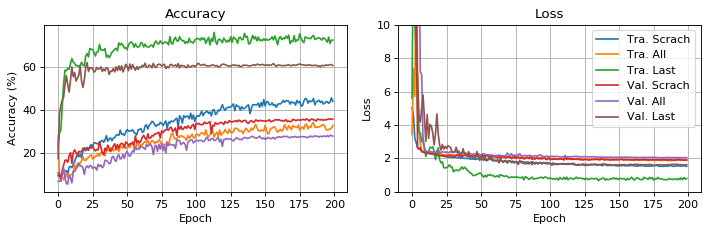

In [7]:
def draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,3), dpi=80)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Accuracy')
    ax1.grid(b=True)
    ax1.plot(train_accu[0], label='Tra. Scrach')
    ax1.plot(train_accu[1], label='Tra. All')
    ax1.plot(train_accu[2], label='Tra. Last')
    ax1.plot(val_accu[0], label='Val. Scrach')
    ax1.plot(val_accu[1], label='Val. All')
    ax1.plot(val_accu[2], label='Val. Last')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss')
    ax2.grid(b=True)
    ax2.set_ylim(0,10)
    ax2.plot(train_loss[0], label='Tra. Scrach')
    ax2.plot(train_loss[1], label='Tra. All')
    ax2.plot(train_loss[2], label='Tra. Last')
    ax2.plot(val_loss[0], label='Val. Scrach')
    ax2.plot(val_loss[1], label='Val. All')
    ax2.plot(val_loss[2], label='Val. Last')

    plt.legend()    
    plt.tight_layout()
    
draw_tri_accuracy(train_accu, train_loss, val_accu, val_loss)

In [8]:
# Evaluation
evaluateset = get_data_set(datadir, 'Food-11/evaluation')
evaluateloader = torch.utils.data.DataLoader(evaluateset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
scheduler = None   
    
for idx in range(3): #0:model_scrach, 1:model_all, 2:model_last
    print('Evaluation of mode {}.'.format(mode[idx]))
    fname = './ckpt/model_best_'+mode[idx]+'.pth.tar'
    model = models.resnet18()
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    model.load_state_dict(torch.load(fname))
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
    
    train_model(evaluateloader, model, criterion, optimizer, 0, scheduler, False)
    
    del model
    del optimizer

Evaluation of mode scrach.
            testing accuracy: 34.9%
                    loss    : 1.889
Evaluation of mode all.
            testing accuracy: 28.4%
                    loss    : 2.042
Evaluation of mode last.
            testing accuracy: 63.7%
                    loss    : 2.185
